In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import mne

import mni_utils as uti
from mni_plots import plot_corr, plot_sc_fit, plot_stages_diff

### Paths and names

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
res_dir = "Results_SC"
res_tau_dir = "Results_acf_fit_exp"
res_exp_dir = "Results_psd_exp"
res_path = data_path.joinpath(res_dir)
res_tau_path = data_path.joinpath(res_tau_dir)
res_exp_path = data_path.joinpath(res_exp_dir)

## 1) Load SC parameters, timescales and parcellation

Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

SC results and parameters:

In [5]:
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the total binned data
df_sc_bins_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_bins.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Fitted on binned distance:
df_sc_params_mni_stages_bins = {
    stage: pd.read_csv(
        res_path.joinpath(f"SC_{stage}_fit_mni_regs_bins.csv"), index_col=0
    )
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters on each MMP region
df_sc_params_mmp_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mmp_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Fitted on binned distance:
df_sc_params_mmp_stages_bins = {
    stage: pd.read_csv(
        res_path.joinpath(f"SC_{stage}_fit_mmp_regs_bins.csv"), index_col=0
    )
    for stage in ["W", "N3", "R"]
}

Timescales:

In [6]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(res_tau_path.joinpath("all_tau.csv"), index_col=0)

# Dataframe with information on parcellated timescales values
df_tau_parc = {
    stage: pd.read_csv(res_tau_path.joinpath(f"tau_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

Exponent:

In [7]:
df_exp = pd.read_csv(res_exp_path.joinpath("all_knee.csv"), index_col=0)

# Dataframe with information on parcellated timescales values
df_exp_parc = {
    stage: pd.read_csv(res_exp_path.joinpath(f"exp_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

## 2) Plot SC parameters globally and for each region

Plot of fits:

{'W': array([10.31544796,  0.28810056,  0.04850013]), 'N3': array([8.30565901, 0.25270324, 0.06400945]), 'R': array([7.88810727, 0.23313814, 0.04821154])}


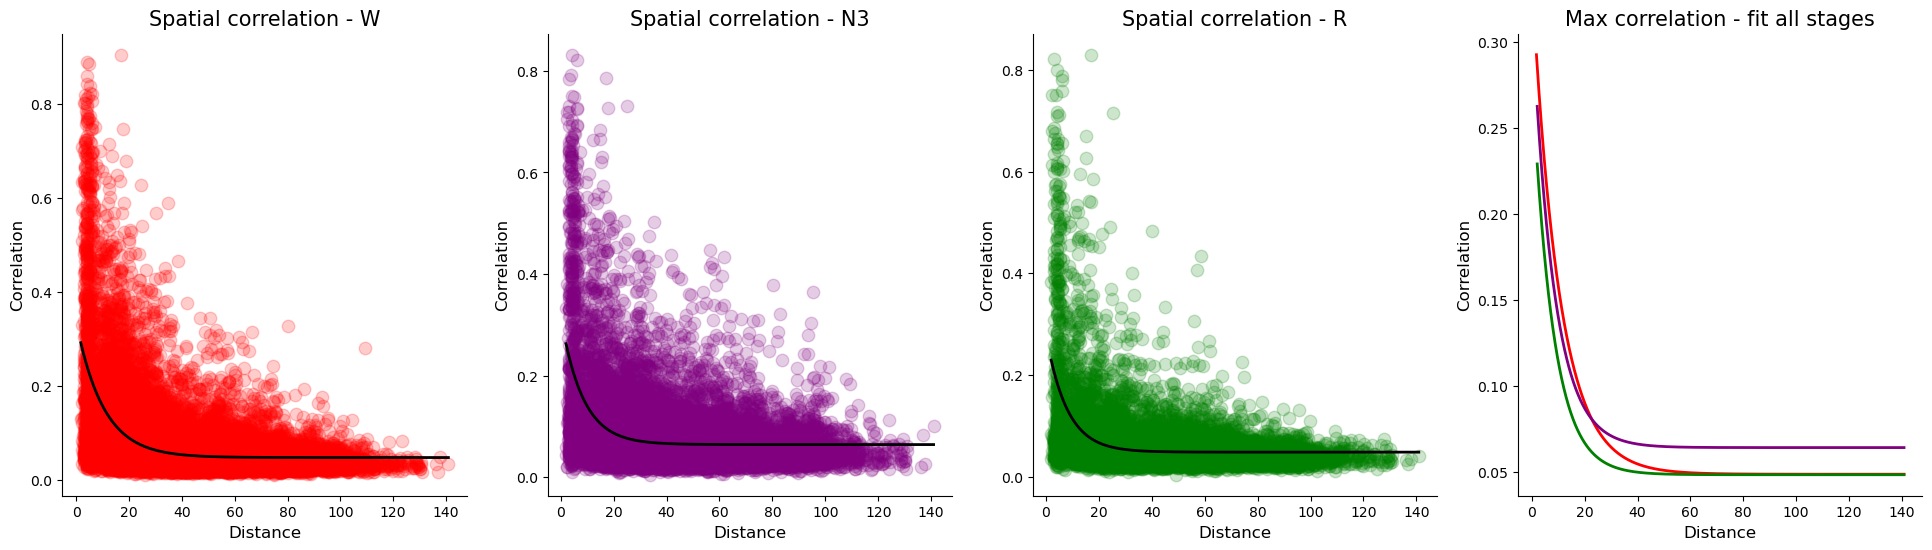

In [8]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages.items()
}
print(params_stages)
fig, axs = plot_sc_fit(df_sc_stages, params_stages, colors_stage)
plt.show()

Plot of regions, "b" parameter:

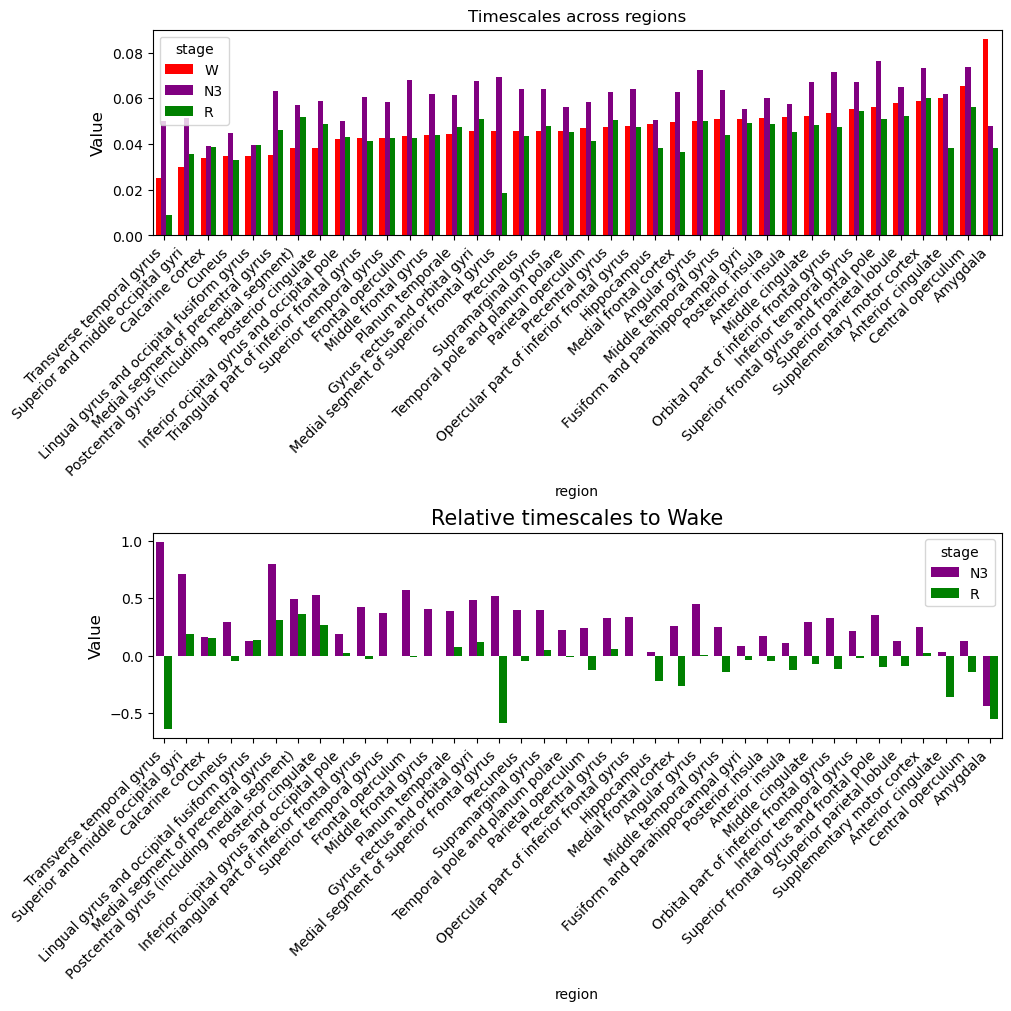

In [9]:
for stage, df in df_sc_params_mni_stages.items():
    if "stage" not in df.columns:
        df.insert(0, "stage", stage)

df_params = pd.concat(df_sc_params_mni_stages.values())
df_params.reset_index(names="region", inplace=True)

fig, axs = plot_stages_diff(df_params, "b")
plt.show()

## 3) Plot relationship between timescales and SC parameters

In [8]:
map_coords = pd.read_csv(data_path.joinpath("mnia_centroids_coords.csv"), index_col=0)

With the fit on all electrodes pairs:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


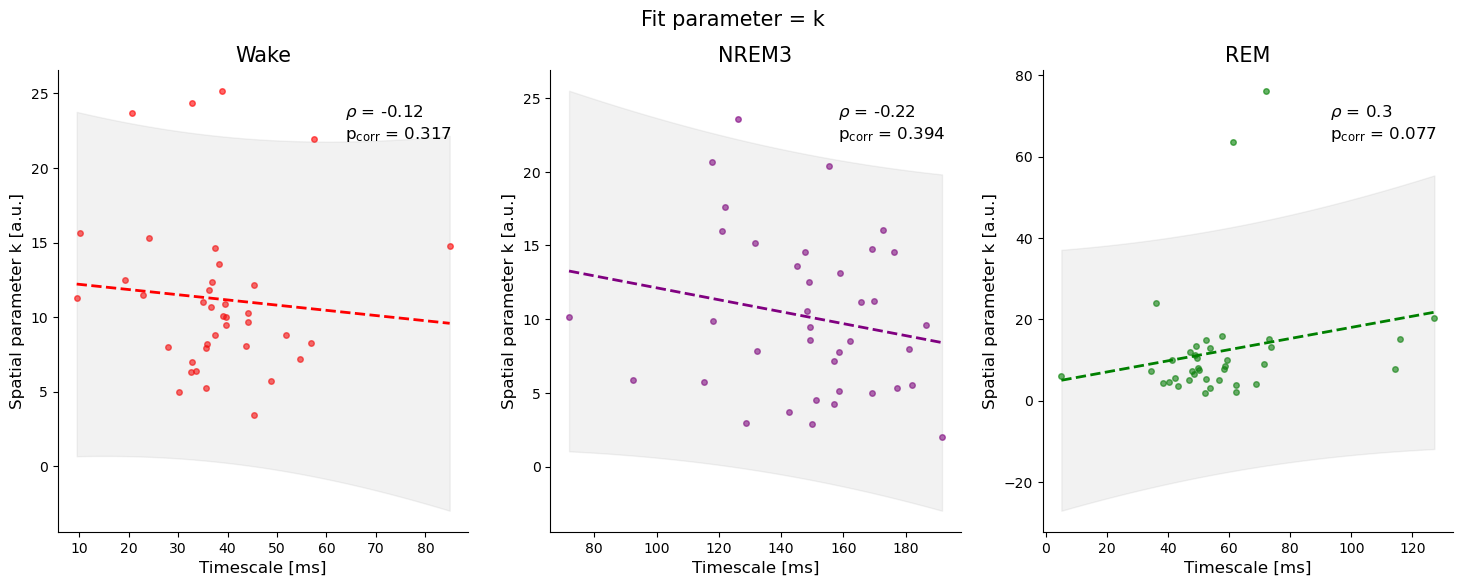

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


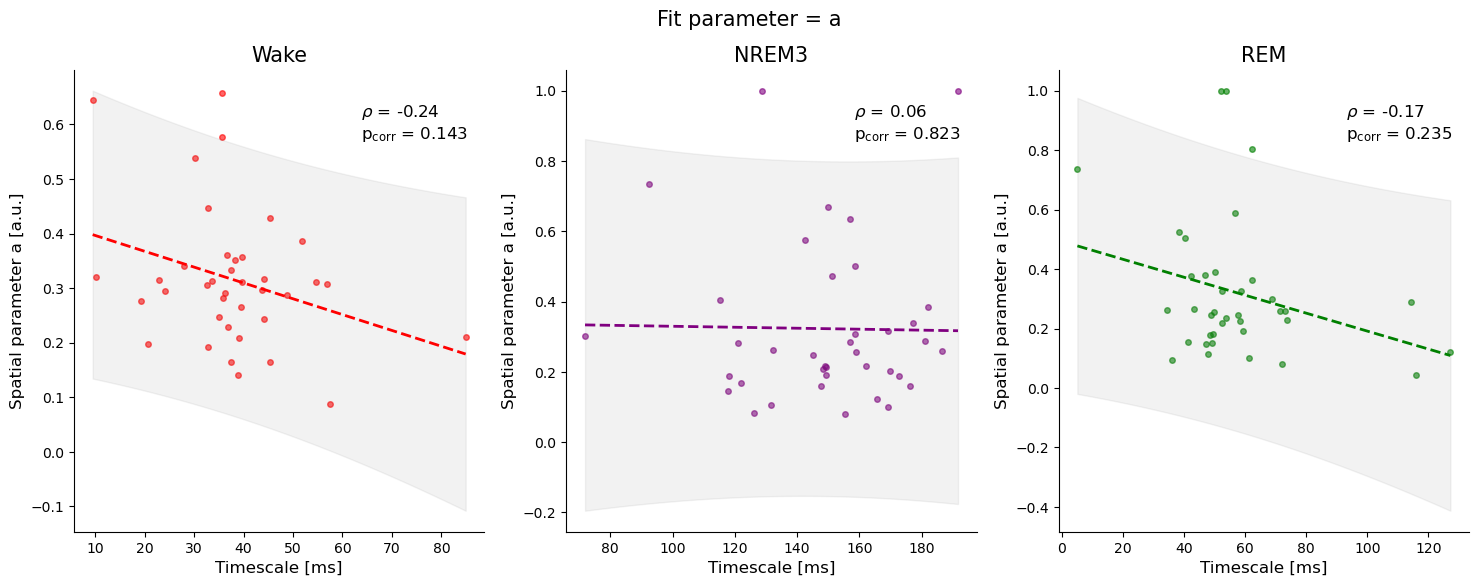

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


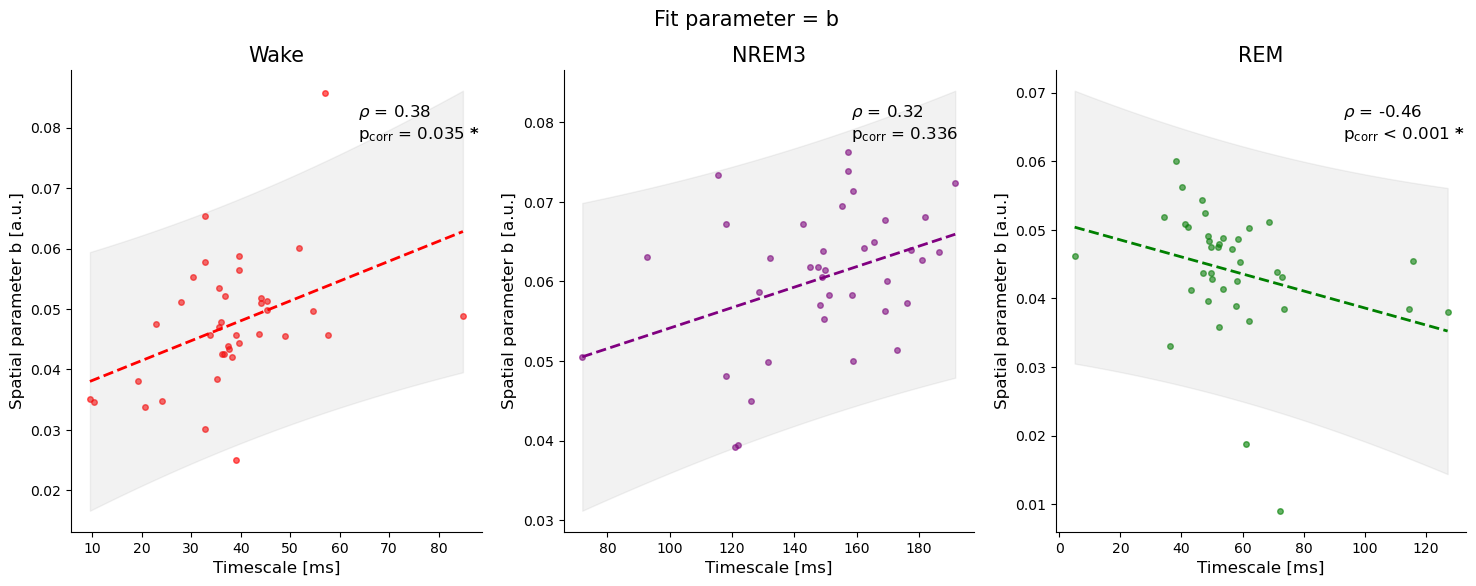

In [11]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage

    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")


        # Get average tau per MNI region

        df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot

        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )


    plt.show()

With the fit on bins:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


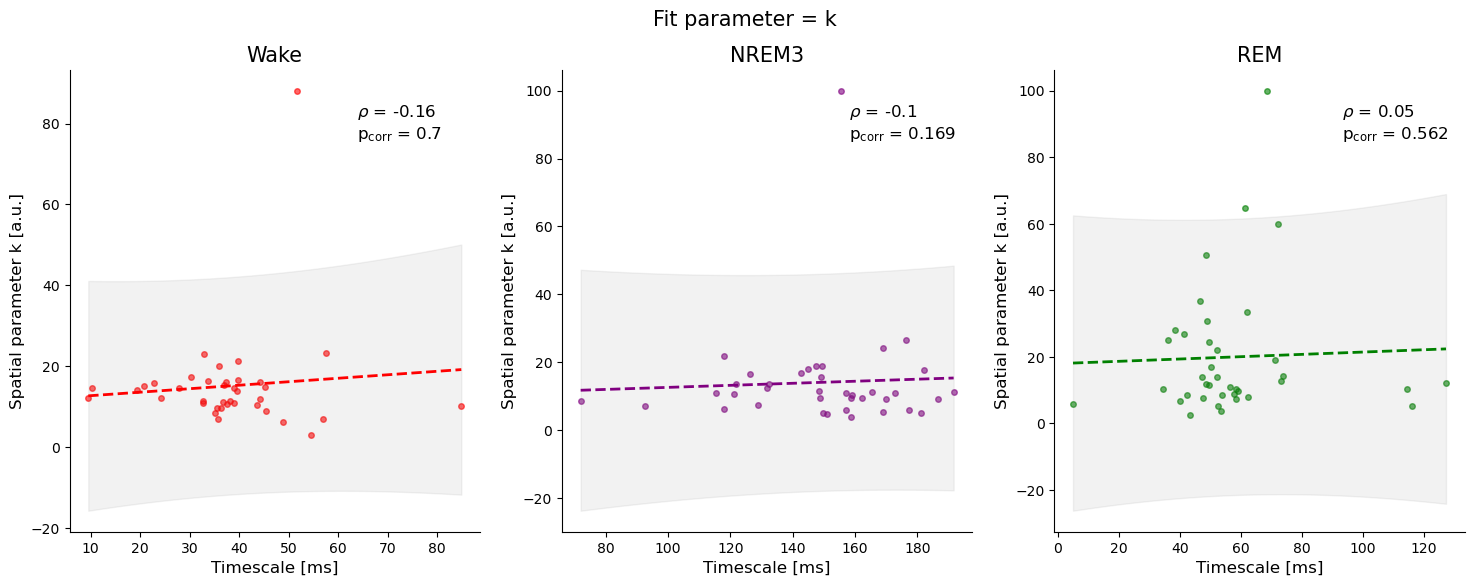

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


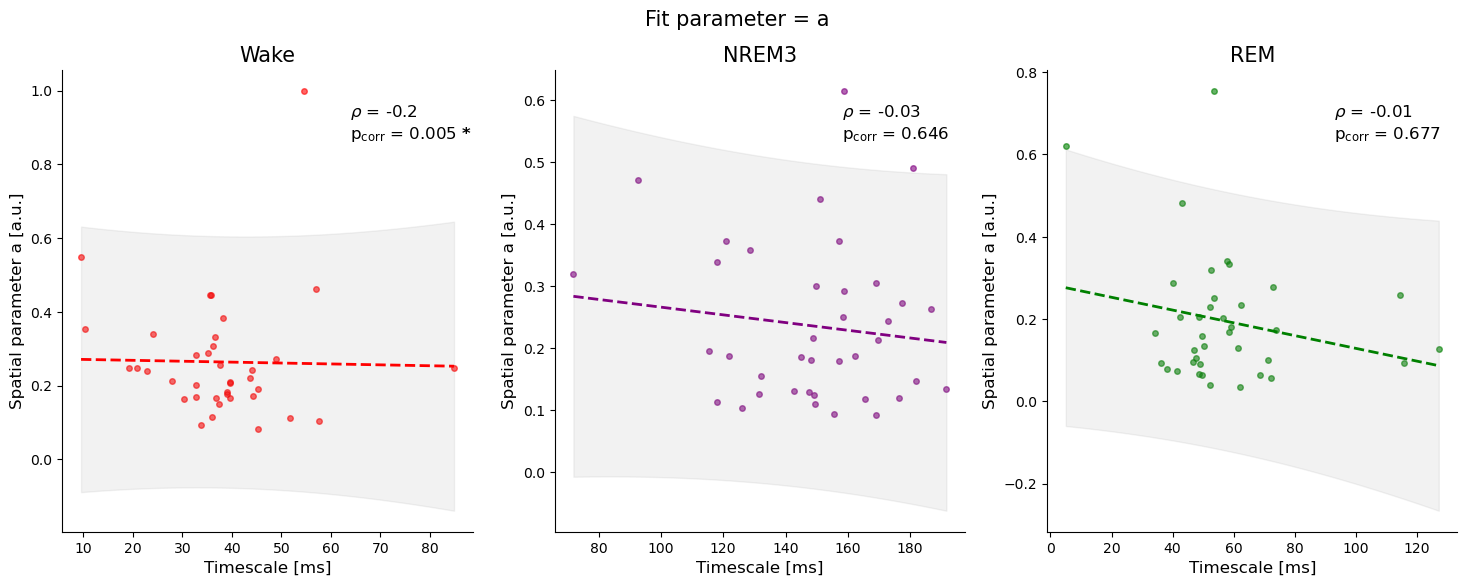

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


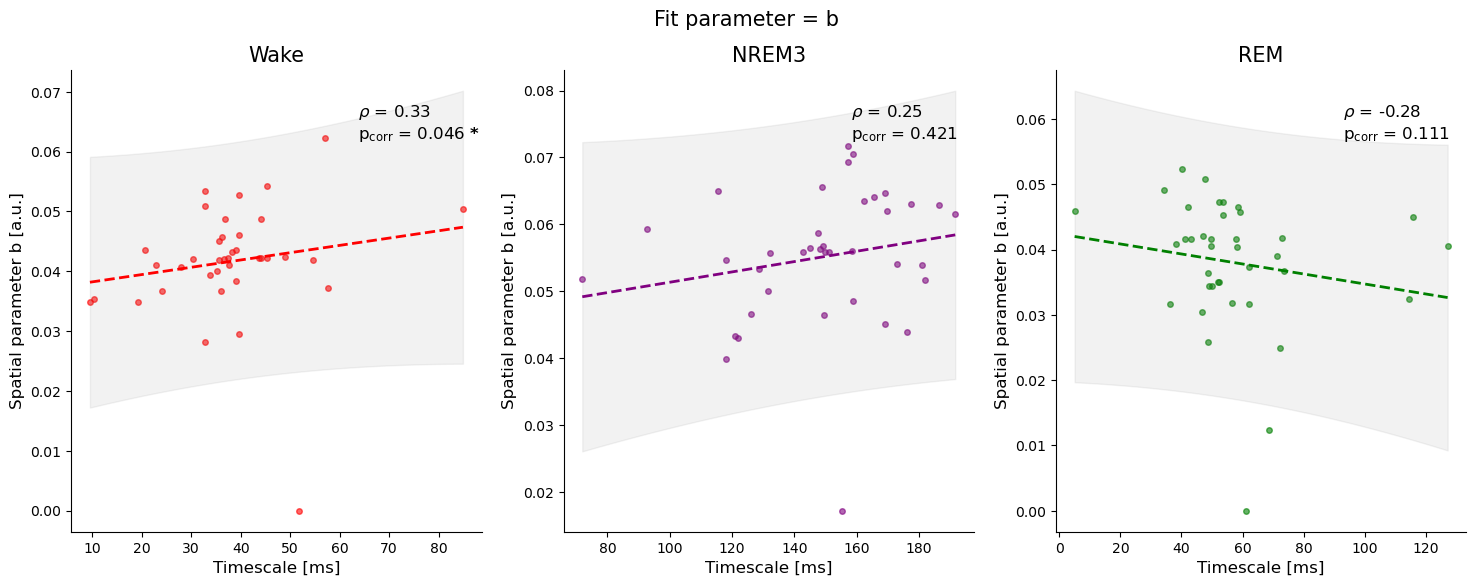

In [12]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_bins[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    plt.show()

## 3) Plot relationship between exponent and SC parameters

With the fit on all electrodes pairs:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


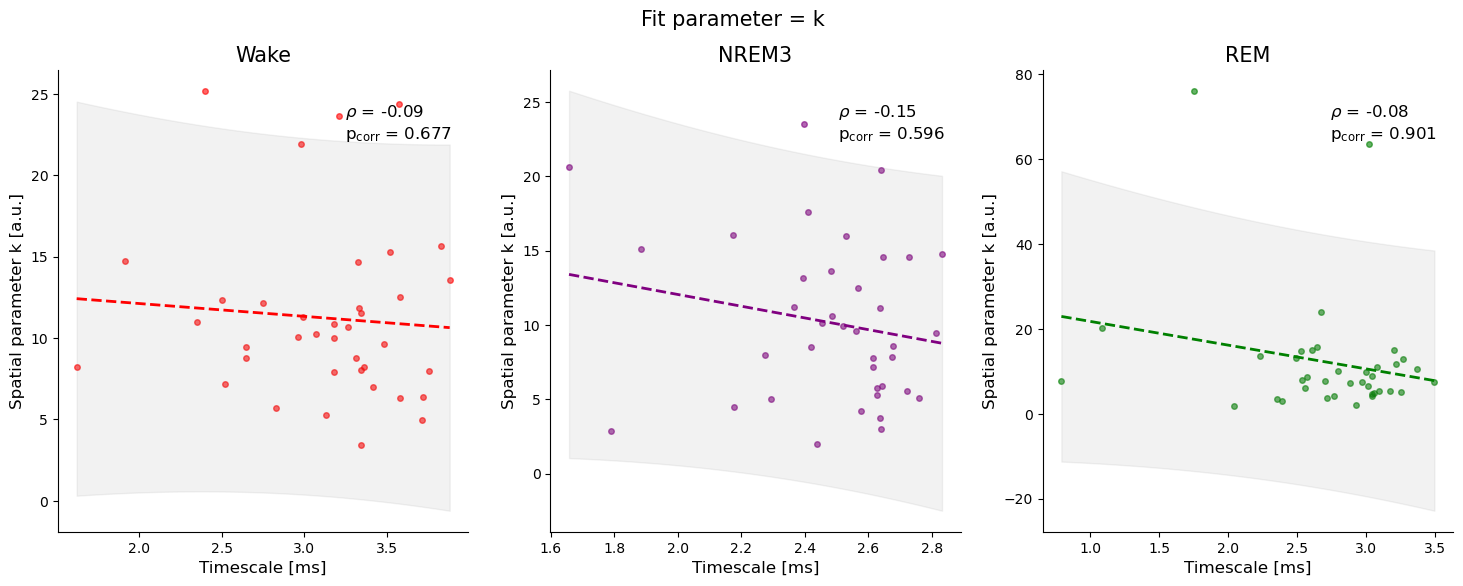

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


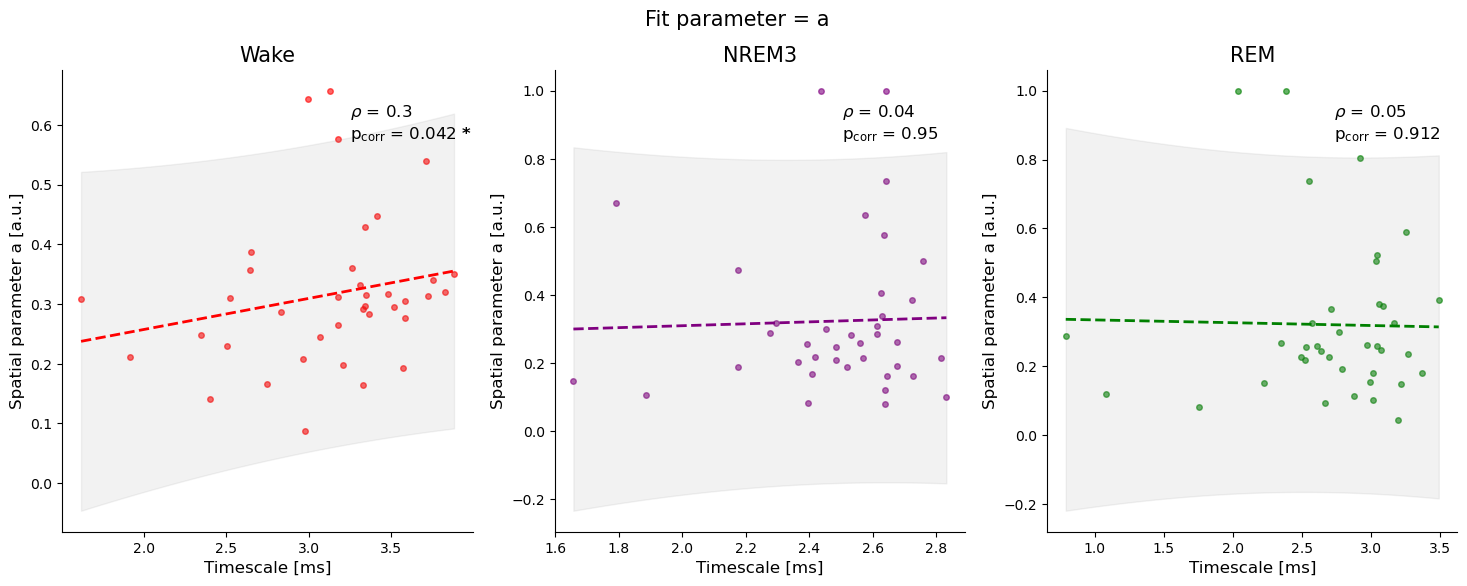

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


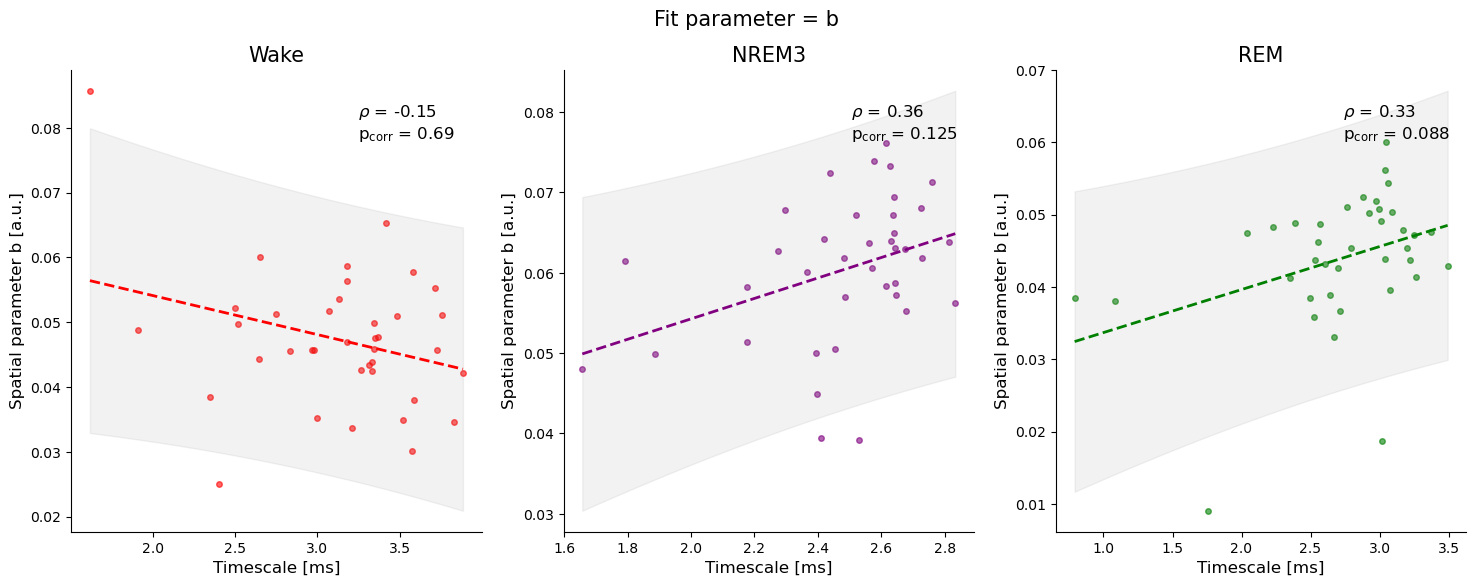

In [19]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage

    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_exp_stage = df_exp[df_exp["stage"] == stage].drop(columns="tau")
        df_exp_stage_mni = uti.get_avg_tau_mni(
            df_exp_stage, metric_name="exp"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_exp_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_exp_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot

        axs[i] = plot_corr(
            axs[i],
            df_exp_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    plt.show()

With the fit on bins:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


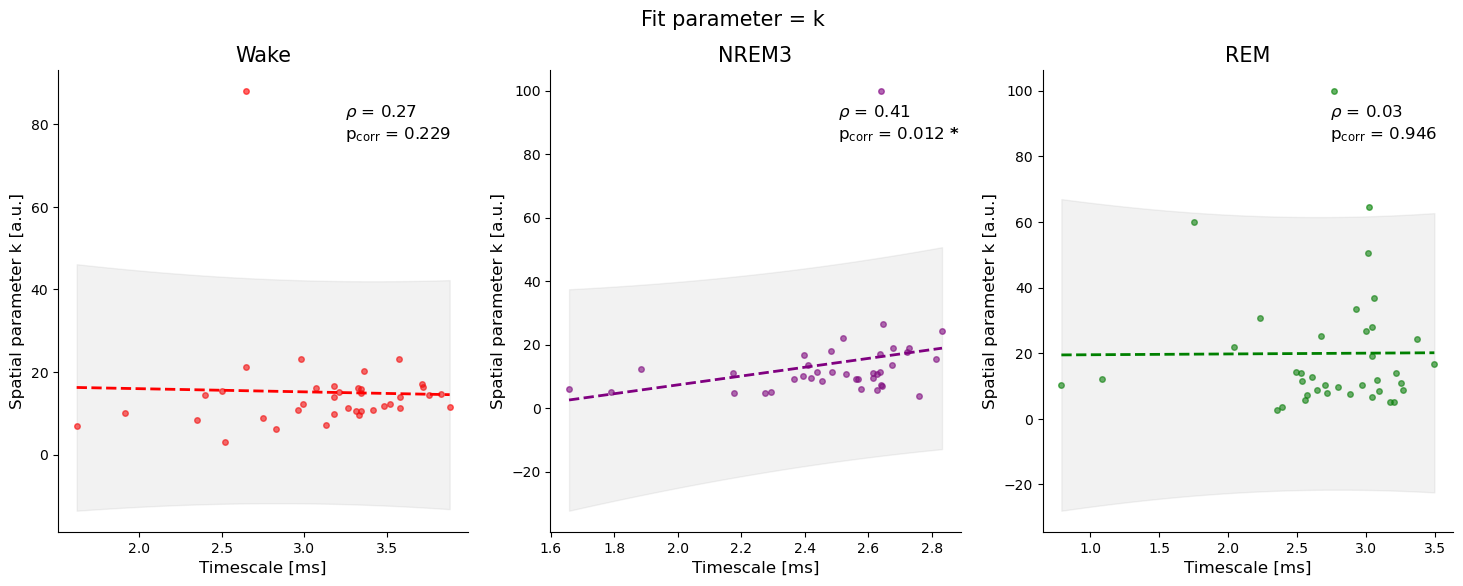

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


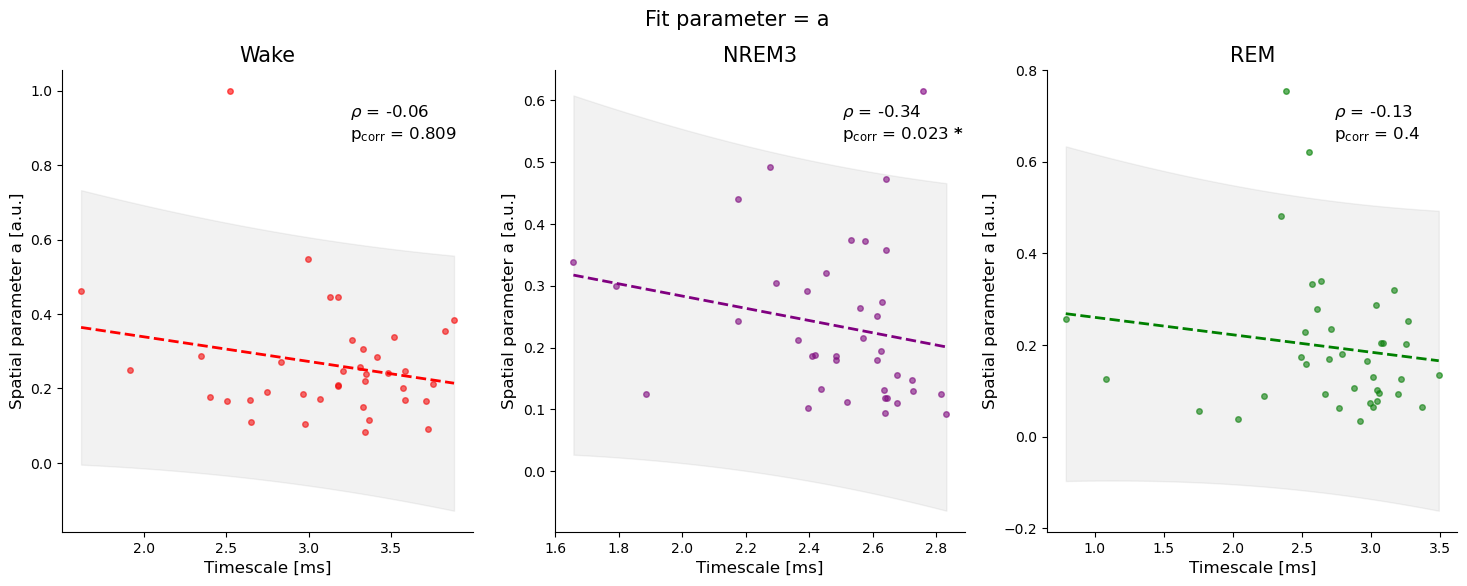

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


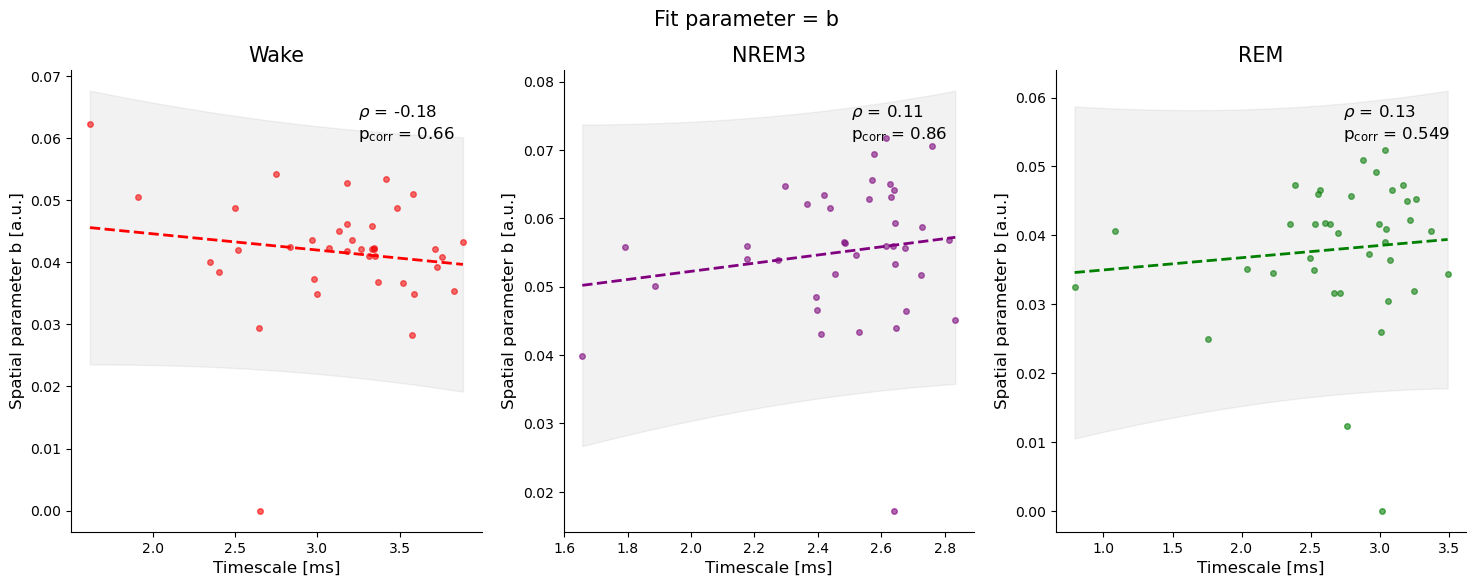

In [20]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_exp_stage = df_exp[df_exp["stage"] == stage].drop(columns="tau")
        df_exp_stage_mni = uti.get_avg_tau_mni(
            df_exp_stage, metric_name="exp"
        )

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_bins[stage][param].astype(float)
        df_spa = df_spa.loc[df_exp_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_exp_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_exp_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    plt.show()